In [6]:
import pandas as pd
from sklearn.ensemble import IsolationForest

books_df = pd.read_csv('books.csv', sep=';', encoding='latin-1', low_memory=False, on_bad_lines='skip', quoting=1)

rating_df = pd.read_csv('ratings.csv', sep=';',
                        encoding='latin1', on_bad_lines='skip')

users_df = pd.read_csv('users.csv', sep=';',
                       encoding='latin1', on_bad_lines='skip')

In [23]:
# Anomaly Detection

#removing users who have not rated a book : where book-rating = 0
rating_df = rating_df[~(rating_df['Book-Rating'] == 0)]

user_features = rating_df.groupby('User-ID').agg({
    'Book-Rating': ['count', 'var', 'mean']  # creating rating count, variance, average
}).reset_index()

user_features.columns = ['User-ID', 'rating_count', 'rating_variance', 'rating_mean']

# Fill missing variance
user_features['rating_variance'] = user_features['rating_variance'].fillna(0)

anomaly_features = user_features[['rating_count', 'rating_variance', 'rating_mean']]
iso_forest = IsolationForest(contamination=0.1, random_state=42)
user_features['anomaly'] = iso_forest.fit_predict(anomaly_features)

# Compute anomaly scores (lower is more anomalous)
user_features['anomaly_score'] = iso_forest.decision_function(anomaly_features)

# Flag anomalous users (-1 indicates anomaly, 1 indicates normal)
anomalous_users = user_features[user_features['anomaly'] == -1].sort_values('anomaly_score')  # Sort by anomaly score

print(f"Number of anomalous users flagged: {len(anomalous_users)}")

Number of anomalous users flagged: 7421


anomaly_label
Normal Users       70384
Anomalous Users     7421
Name: count, dtype: int64


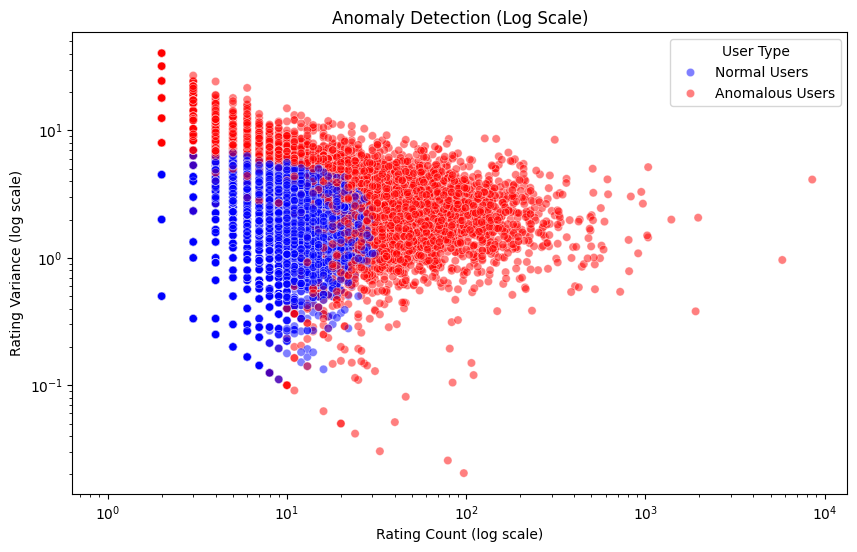


Anomalous Users Report (Top 10, sorted by anomaly score):
Categories:
- High rating count: Above 90th percentile (many ratings, e.g., bots)
- Low rating variance: Below 10th percentile (uniform ratings, e.g., all 10s)
- High rating variance: Above 90th percentile (erratic ratings, e.g., 0s and 10s)
- Extreme rating mean: <2.5 or >8.5 (biased ratings, 0-10 scale)
- Unusual feature combination: Deviant combination of count, variance, mean
User 76499: High rating count: 1036, High rating variance: 5.15, Extreme rating mean: 8.93
User 38273: High rating count: 312, High rating variance: 8.46
User 51883: High rating count: 363, High rating variance: 4.18, Extreme rating mean: 9.01
User 182085: High rating count: 512, Extreme rating mean: 8.74
User 114368: High rating count: 614, High rating variance: 4.13
User 76151: High rating count: 181, High rating variance: 5.73, Extreme rating mean: 8.83
User 63714: High rating count: 811, Extreme rating mean: 9.37
User 123883: High rating count: 454

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map anomaly values to labels
user_features['anomaly_label'] = user_features['anomaly'].map({1: 'Normal Users', -1: 'Anomalous Users'})

print(user_features['anomaly_label'].value_counts())

plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_features, x='rating_count', y='rating_variance',
                hue='anomaly_label', palette={'Normal Users': 'blue', 'Anomalous Users': 'red'}, alpha=0.5)

plt.xscale('log')  # Spread out rating count
plt.yscale('log')  # Spread out rating variance
plt.xlabel('Rating Count (log scale)')
plt.ylabel('Rating Variance (log scale)')
plt.title('Anomaly Detection (Log Scale)')
plt.legend(title='User Type')
plt.show()

# Report reasons for anomalous users
print("\nAnomalous Users Report (Top 10, sorted by anomaly score):")
print("Categories:")
print("- High rating count: Above 90th percentile (many ratings, e.g., bots)")
print("- Low rating variance: Below 10th percentile (uniform ratings, e.g., all 10s)")
print("- High rating variance: Above 90th percentile (erratic ratings, e.g., 0s and 10s)")
print("- Extreme rating mean: <2.5 or >8.5 (biased ratings, 0-10 scale)")
print("- Unusual feature combination: Deviant combination of count, variance, mean")

# Precompute thresholds
high_count_thresh = user_features['rating_count'].quantile(0.90)
low_var_thresh = user_features['rating_variance'].quantile(0.10)
high_var_thresh = user_features['rating_variance'].quantile(0.90)

def explain_reason(row):
    reasons = []
    if row['rating_count'] > high_count_thresh:
        reasons.append(f"High rating count: {int(row['rating_count'])}")
    if row['rating_variance'] < low_var_thresh:
        reasons.append(f"Low rating variance: {row['rating_variance']:.2f}")
    if row['rating_variance'] > high_var_thresh:
        reasons.append(f"High rating variance: {row['rating_variance']:.2f}")
    if row['rating_mean'] < 2.5 or row['rating_mean'] > 8.5:
        reasons.append(f"Extreme rating mean: {row['rating_mean']:.2f}")
    if not reasons:
        reasons.append(f"Unusual feature combination, anomaly score: {row['anomaly_score']:.3f}")
    return ", ".join(reasons)

# Apply to top 10 anomalous users
anomalous_users_top10 = anomalous_users.head(10).copy()
anomalous_users_top10['reason'] = anomalous_users_top10.apply(explain_reason, axis=1)

for _, row in anomalous_users_top10.iterrows():
    print(f"User {row['User-ID']}: {row['reason']}")

# Filter out anomalous users from ratings
ratings = rating_df[~rating_df['User-ID'].isin(anomalous_users['User-ID'])]